In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import json
import collections
import random
from PIL import Image


plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

In [2]:
image_path = 'train2014'

In [3]:
# Chemin du fichier d'annotations
annotation_folder = os.path.abspath('.')+"/annotations/"
annotation_file = annotation_folder+"captions_train2014.json"

# Chemin du dossier contenant les images à annoter
image_path = '/train2014/'
PATH = os.path.abspath('.') + image_path

print("Fichier d'annotation : ", annotation_file)
print("Le chemin PATH : ", PATH)

Fichier d'annotation :  c:\Projet IA\Projet\DSCESI\Captionning/annotations/captions_train2014.json
Le chemin PATH :  c:\Projet IA\Projet\DSCESI\Captionning/train2014/


In [4]:
with open(annotation_folder+"/captions_val2014.json", 'r') as f:
    annotations = json.load(f)

with open(annotation_folder+"instances_val2014.json", 'r') as f:
    instances = json.load(f)
    
print("Annotations et instances chargées.")

Annotations et instances chargées.


In [5]:
# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = f"{val['caption']}"
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)
    
print("Préparation terminée.")

Préparation terminée.


In [6]:
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:10000]

print("Nombres d'images utilisées :", len(train_image_paths))

Nombres d'images utilisées : 10000


In [7]:
# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))

# Création du DataFrame
df = pd.DataFrame({"image": img_name_vector, "caption": train_captions})

# Sauvegarde en CSV
df.to_csv("image_captions.csv", index=False)

print("Préparation terminée. CSV créé avec succès.")

Préparation terminée. CSV créé avec succès.


In [8]:
data = pd.read_csv("image_captions.csv")
data.head()

,image,caption
0,COCO_train2014_000000032562.jpg,A car parked next to an airplane on a field.
1,COCO_train2014_000000032562.jpg,an old school black car is next to an airplane
2,COCO_train2014_000000032562.jpg,An old timey car and a large airplane are on d...
3,COCO_train2014_000000032562.jpg,An antique car in front of a plane and a crowd...
4,COCO_train2014_000000032562.jpg,A vintage airplane next to a vintage automobile.


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50019 entries, 0 to 50018
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    50019 non-null  object
 1   caption  50019 non-null  object
dtypes: object(2)
memory usage: 781.7+ KB


In [10]:
image_path = 'train2014'

In [11]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"train2014/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

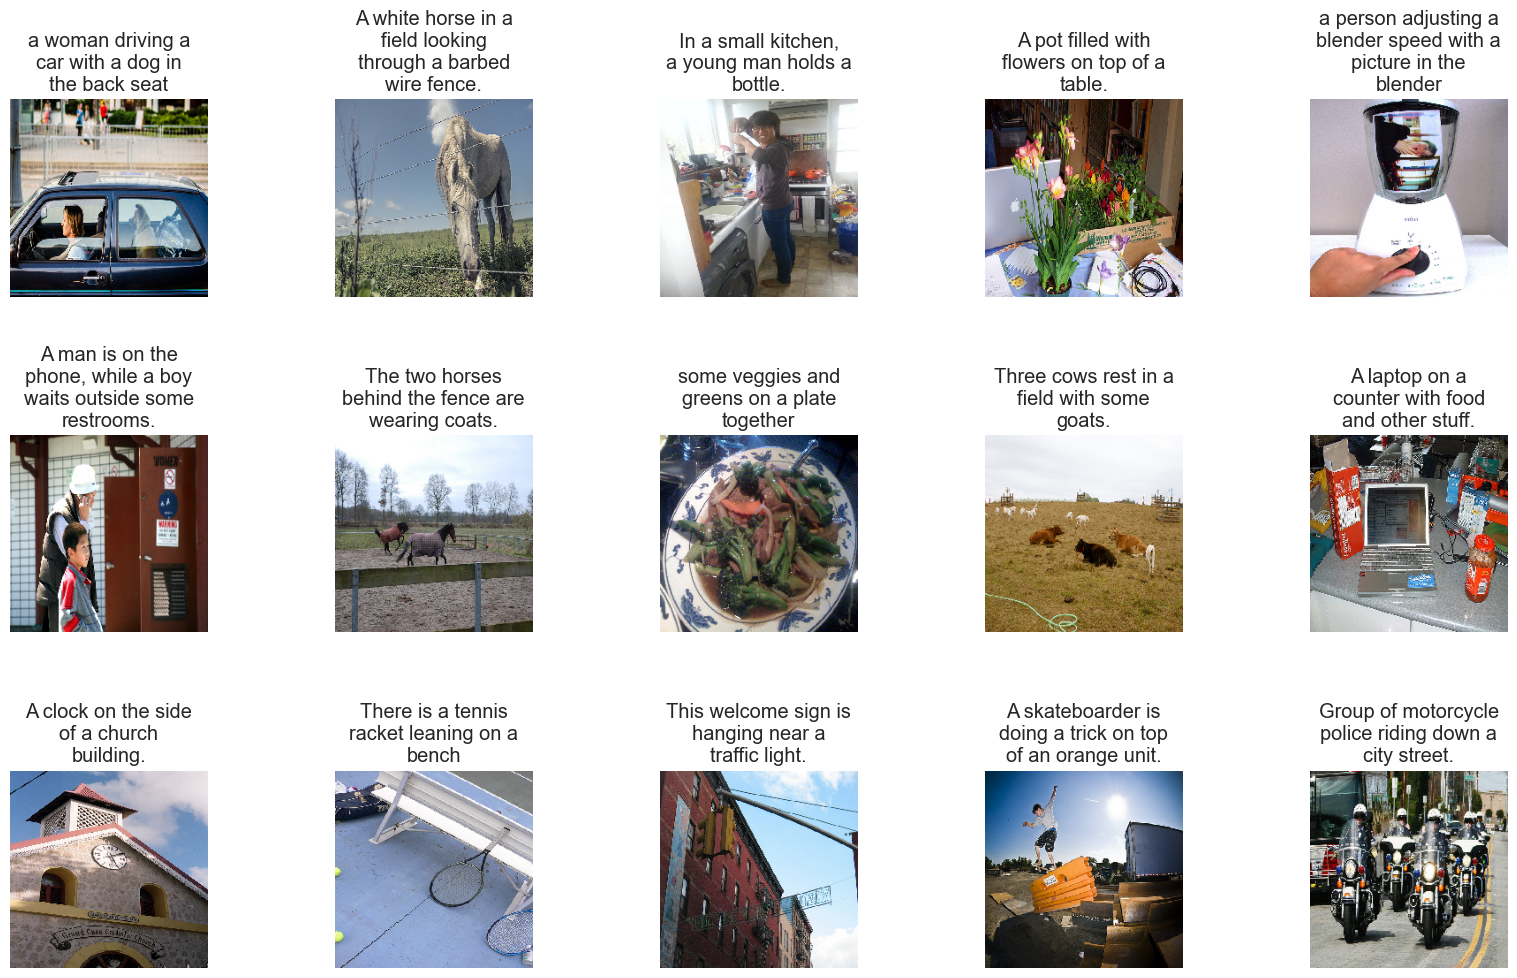

In [12]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [13]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [14]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq car parked next to an airplane on field. endseq',
 'startseq an old school black car is next to an airplane endseq',
 'startseq an old timey car and large airplane are on display endseq',
 'startseq an antique car in front of plane and crowd of people. endseq',
 'startseq vintage airplane next to vintage automobile. endseq',
 'startseq man standing on tennis court holding racquet. endseq',
 'startseq person is striking tennis ball at game endseq',
 'startseq person jumping into the air on tennis court. endseq',
 'startseq an overweight tennis player is serving ball. endseq',
 'startseq person is playing tennis in an empty court. endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 14, 134, 790, 37, 145, 9, 19, 11, 14, 170, 2]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

In [16]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

 27%|██▋       | 2702/10000 [12:52<2:34:44,  1.27s/it]

# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [33]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [34]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [15]:
# from tensorflow.keras.utils import plot_model

## **Model Modification**
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

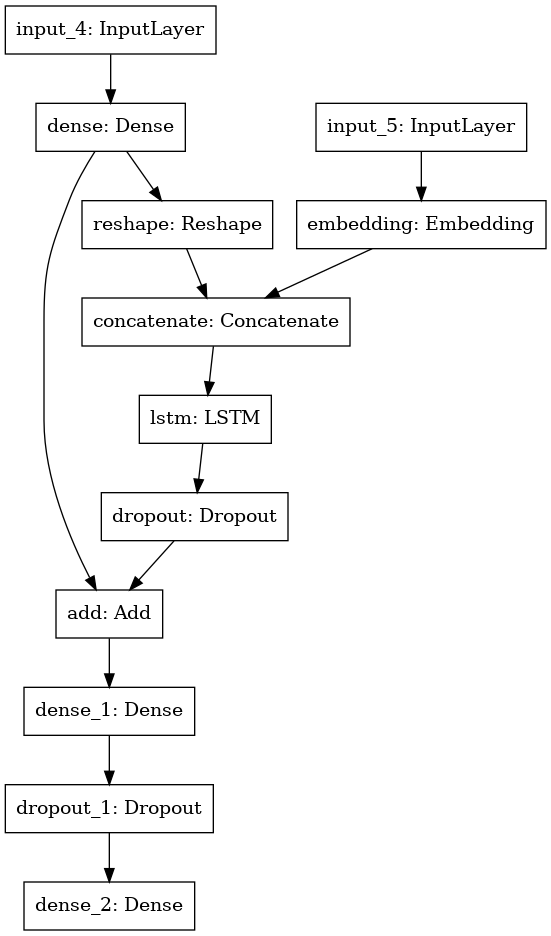

In [16]:
# plot_model(caption_model)

In [35]:
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  491776    ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 42)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                            

In [36]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [37]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

## **Let's train the Model !**

<img src='https://miro.medium.com/max/1400/1*xIXqf46yYonSXkUOWcOCvg.gif'>

In [38]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50

664/664 [==============================] - ETA: 0s - loss: 5.1290
Epoch 1: val_loss improved from inf to 4.28869, saving model to model.h5
664/664 [==============================] - 1559s 2s/step - loss: 5.1290 - val_loss: 4.2887 - lr: 0.0010
Epoch 2/50
664/664 [==============================] - ETA: 0s - loss: 4.2072
Epoch 2: val_loss improved from 4.28869 to 3.93934, saving model to model.h5
664/664 [==============================] - 368s 554ms/step - loss: 4.2072 - val_loss: 3.9393 - lr: 0.0010
Epoch 3/50
664/664 [==============================] - ETA: 0s - loss: 3.9372
Epoch 3: val_loss improved from 3.93934 to 3.82347, saving model to model.h5
664/664 [==============================] - 362s 544ms/step - loss: 3.9372 - val_loss: 3.8235 - lr: 0.0010
Epoch 4/50
664/664 [==============================] - ETA: 0s - loss: 3.7729

# **Inference**
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

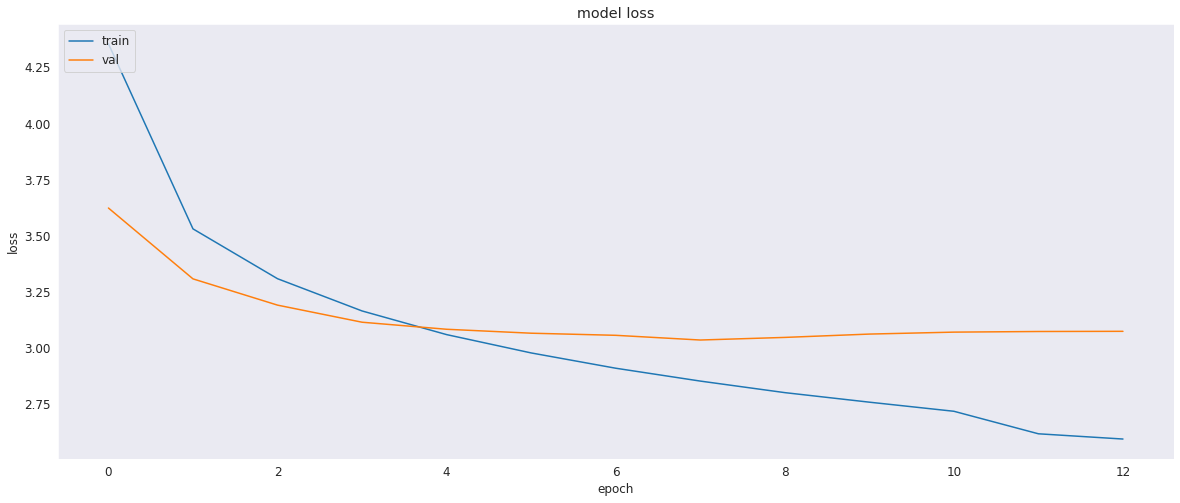

In [21]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [22]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [23]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

## **Taking 15 Random Samples for Caption Prediction**

In [25]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [26]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

# **Results**
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

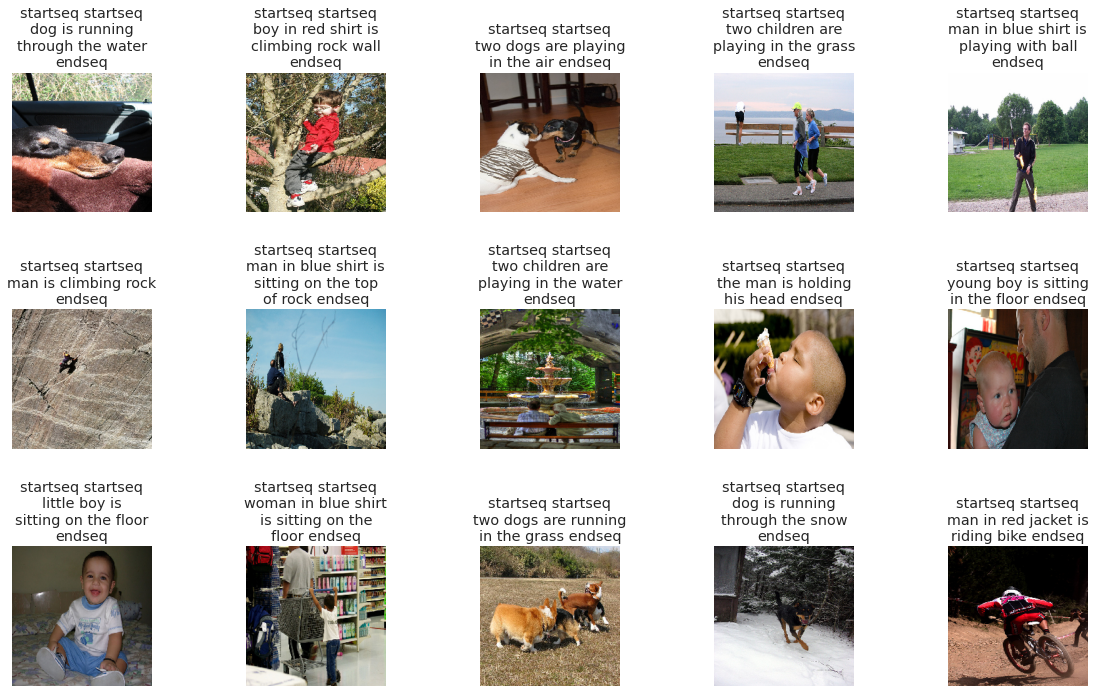

In [27]:
display_images(samples)

<p style='font-size: 18px'><strong>Conclusion: </strong>This may not be the best performing model, but the objective of this kernel is to give a gist of how Image Captioning problems can be approached. In the future work of this kernel <strong>Attention model</strong> training and <strong>BLEU Score</strong> assessment will be performed.</p>